<a href="https://colab.research.google.com/github/AlexeyLitovchenko/4_course_spring_26/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders, GANs, and Diffusion Models

In [ ]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
    return metric.compute()

In [ ]:
def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs, patience=2, factor=0.5, epoch_callback=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=patience, factor=factor
    )
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        if epoch_callback is not None:
            epoch_callback(model, epoch)
        for index, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
            print(f"\rBatch {index + 1}/{len(train_loader)}", end="")
            print(f", loss={total_loss/(index+1):.4f}", end="")
            print(f", {train_metric=:.3f}", end="")
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"\rEpoch {epoch + 1}/{n_epochs},                      "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.3}, "
              f"valid metric: {history['valid_metrics'][-1]:.3}")
    return history

## Performing PCA with an Undercomplete Linear Autoencoder

In [ ]:
import torch
import torch.nn as nn

torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed=42):
    X = np.zeros((m, 3))  # initialize 3D dataset
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
    X += 0.28 * rng.standard_normal((m, 3))  # add more noise
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]  # shift a bit
    return torch.from_numpy(X.astype(np.float32))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_train = generate_data(60, seed=42)
train_set = TensorDataset(X_train, X_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [ ]:
X_valid = generate_data(500, seed=43)
valid_set = TensorDataset(X_valid, X_valid)
valid_loader = DataLoader(valid_set, batch_size=32)

In [ ]:
import torchmetrics

torch.manual_seed(42)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr=0.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(autoencoder, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=20)

In [ ]:
codings = encoder(X_train.to(device))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
rng = np.random.default_rng(seed=42)
angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * rng.standard_normal((m, 3))  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])


plt.show()

In [ ]:
fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## Stacked Autoencoders


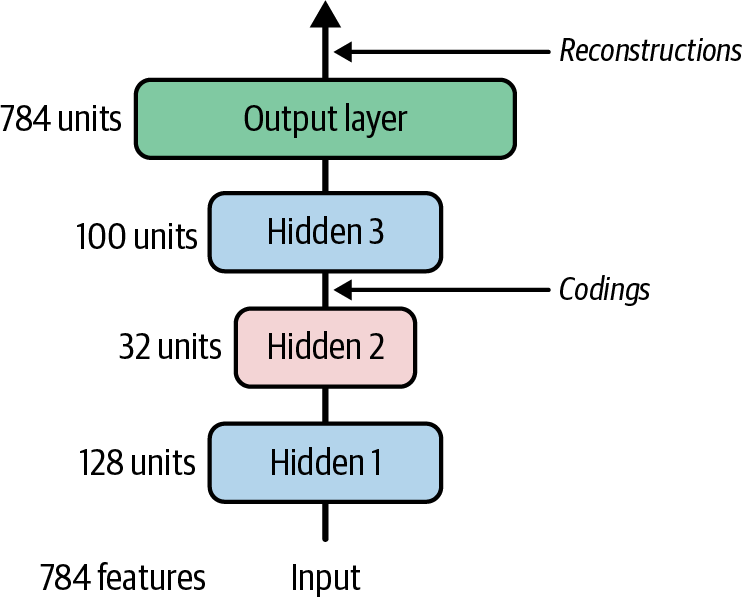

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 32), nn.ReLU(),
)
stacked_decoder = nn.Sequential(
    nn.Linear(32, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
stacked_ae = nn.Sequential(stacked_encoder, stacked_decoder).to(device)

In [ ]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [ ]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        return x, x

train_loader = DataLoader(AutoencoderDataset(train_data), batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(AutoencoderDataset(valid_data), batch_size=32)
test_loader = DataLoader(AutoencoderDataset(test_data), batch_size=32)

In [ ]:
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr=0.01)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(stacked_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_reconstructions(model, images, n_images=5):
    images = images[:n_images]
    with torch.no_grad():
        y_pred = model(images.to(device))
    if isinstance(y_pred, tuple):
        y_pred = y_pred.output
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), 1 + idx)
        plot_image(images[idx])
        plt.subplot(2, len(images), 1 + len(images) + idx)
        plot_image(y_pred[idx])

In [ ]:
X_valid = torch.stack([x for x, _ in valid_data])
plot_reconstructions(stacked_ae, X_valid)

plt.show()


#### Using AutoEncoders for Anomaly Detection

In [ ]:
torch.manual_seed(42)
mnist_data = torchvision.datasets.MNIST(
    root="datasets", train=True, download=True, transform=toTensor)
mnist_images = torch.stack([mnist_data[i][0] for i in range(X_valid.size(0))])
plot_reconstructions(stacked_ae, images=mnist_images)

plt.show()

In [ ]:
images = mnist_images.to(device)
with torch.no_grad():
    y_pred = stacked_ae(images)
    recon_loss = torch.nn.functional.mse_loss(y_pred, images)

recon_loss

In [ ]:
import torch.nn.functional as F

def compute_reconstruction_losses(X, device):
    X = X.to(device)
    with torch.no_grad():
        y_pred = stacked_ae(X)
        return F.mse_loss(y_pred, X, reduction="none").view(X.size(0), -1).mean(dim=1).cpu()

recon_losses_mnist = compute_reconstruction_losses(mnist_images, device)
recon_losses_fashion_mnist = compute_reconstruction_losses(X_valid, device)

plt.hist(recon_losses_mnist, bins=85, alpha=0.8, label="MNIST images")
plt.hist(recon_losses_fashion_mnist, bins=85, alpha=0.8, label="Fashion MNIST images")
plt.xlabel("Reconstruction loss (MSE)")
plt.ylabel("Count", rotation=0)
plt.legend()
plt.grid()

plt.show()

#### Visualizing the Fashion MNIST Dataset

In [ ]:
from sklearn.manifold import TSNE

with torch.no_grad():
    X_valid_compressed = stacked_encoder(X_valid.to(device))

tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed.cpu())

In [ ]:
y_valid = torch.tensor([y for _, y in valid_data])

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index].squeeze(dim=0),
                                      cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

plt.show()

### Convolutional Autoencoders

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

conv_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 16 × 14 × 14
    nn.Conv2d(16, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 32 × 7 × 7
    nn.Conv2d(32, 64, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 64 × 3 × 3
    nn.Conv2d(64, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())  # output: 32

conv_decoder = nn.Sequential(
    nn.Linear(32, 16 * 3 * 3),
    nn.Unflatten(dim=1, unflattened_size=(16, 3, 3)),
    nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.Sigmoid())

conv_ae = nn.Sequential(conv_encoder, conv_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(conv_ae.parameters(), lr=0.005)
history = train(conv_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae, X_valid)
plt.show()

### Extra Material – Recurrent Autoencoders

In [ ]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_size=28, hidden_size=128,
                                    num_layers=2, batch_first=True)
        self.encoder_proj = nn.Linear(128, 32)  # Compress to latent vector
        self.decoder_lstm = nn.LSTM(input_size=32, hidden_size=128,
                                    batch_first=True)
        self.decoder_proj = nn.Linear(128, 28)

    def encode(self, X):  # X shape: [B, 1, 28, 28]
        Z = X.squeeze(dim=1)  # Z shape: [B, 28, 28]
        _, (h_n, _) = self.encoder_lstm(Z)  # h_n shape: [2, B, 100]
        Z = h_n[-1]  # get the hidden state of the last layer: [B, 100]
        return self.encoder_proj(Z)  # [B, 30]

    def decode(self, X):
        Z = X.unsqueeze(dim=1).repeat(1, 28, 1)  # [B, 28, 32]
        Z, _ = self.decoder_lstm(Z)  # [B, 28, 100]
        return F.sigmoid(self.decoder_proj(Z).unsqueeze(dim=1)) # [B, 1, 28, 28]

    def forward(self, X):
        return self.decode(self.encode(X))

torch.manual_seed(42)
recurrent_ae = RecurrentAutoencoder().to(device)

In [ ]:
optimizer = torch.optim.NAdam(recurrent_ae.parameters(), lr=1e-3)
history = train(recurrent_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

### Denoising Autoencoders

Using dropout -> Instead of using Dropout, we can add Gaussian noise

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

dropout_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
dropout_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
dropout_ae = nn.Sequential(dropout_encoder, dropout_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(dropout_ae.parameters(), lr=0.01)
history = train(dropout_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

In [ ]:
# extra code – this cell generates Figure 18–9
torch.manual_seed(42)
dropout = nn.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid))

plt.show()


In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, std):
        super().__init__()
        self.std = std

    def forward(self, X):
        if self.training:  # only add noise during training
            noise = torch.randn_like(X) * self.std
            return X + noise
        return X

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

noise_encoder = nn.Sequential(
    nn.Flatten(),
    GaussianNoise(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
noise_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
noise_ae = nn.Sequential(noise_encoder, noise_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(noise_ae.parameters(), lr=0.01)
history = train(noise_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

In [ ]:
# extra code
torch.manual_seed(42)
noise = GaussianNoise(0.5)
plot_reconstructions(noise_ae, noise(X_valid))
plt.show()

### Sparse Autoencoder


Let's use the sigmoid activation function in the coding layer. Let's also add
 regularization to it: to do this, we make the module return both the reconstructions and the encodings (i.e., the output of the encoder), so the regularization loss can be computed based on the encodings.

In [ ]:
from collections import namedtuple

AEOutput = namedtuple("AEOutput", ["output", "codings"])

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.Sigmoid())
        self.decoder = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        codings = self.encoder(X)
        output = self.decoder(codings)
        return AEOutput(output, codings)

In [ ]:
def mse_plus_sparsity_loss(y_pred, y_target, target_sparsity=0.1,
                           kl_weight=1e-3, eps=1e-8):
    p = torch.tensor(target_sparsity, device=y_pred.codings.device)
    q = torch.clamp(y_pred.codings.mean(dim=0), eps, 1 - eps)  # actual sparsity
    kl_div = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
    return mse(y_pred.output, y_target) + kl_weight * kl_div.sum()

In [ ]:
# Let's plot the KL Divergence loss, versus the MAE and MSE:
plt.figure(figsize=(6, 3.5))
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse_ = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity $p$", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse_, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity $q$")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

In [ ]:
torch.manual_seed(42)
sparse_ae = SparseAutoencoder().to(device)
optimizer = torch.optim.NAdam(sparse_ae.parameters(), lr=0.002)
history = train(sparse_ae, optimizer, mse_plus_sparsity_loss, rmse,
                train_loader, valid_loader, n_epochs=10)

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_ae, X_valid)
plt.show()

In [ ]:
with torch.no_grad():
    y_pred = sparse_ae(X_valid.to(device))

encs = y_pred.codings.flatten().detach().cpu()
plt.hist(encs, log=True)
plt.xlabel("Activation")
plt.ylabel("Count")
plt.show()

In [ ]:
y_pred.codings.mean()

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)

dim = 6
codings = y_pred.codings[:, dim].cpu()
threshold = np.percentile(codings, 90)
selected_images = X_valid[codings > threshold]
plot_multiple_images(selected_images[:35], 7)
plt.show()

### Variational Autoencoder

In [ ]:
VAEOutput = namedtuple("VAEOutput",
                       ["output", "codings_mean", "codings_logvar"])

class VAE(nn.Module):
    def __init__(self, codings_dim=32):
        super(VAE, self).__init__()
        self.codings_dim = codings_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 2 * codings_dim))  # output both the mean and logvar
        self.decoder = nn.Sequential(
            nn.Linear(codings_dim, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def encode(self, X):
        return self.encoder(X).chunk(2, dim=-1)  # returns (mean, logvar)

    def sample_codings(self, codings_mean, codings_logvar):
        codings_std = torch.exp(0.5 * codings_logvar)
        noise = torch.randn_like(codings_std)
        return codings_mean + noise * codings_std

    def decode(self, Z):
        return self.decoder(Z)

    def forward(self, X):
        codings_mean, codings_logvar = self.encode(X)
        codings = self.sample_codings(codings_mean, codings_logvar)
        output = self.decode(codings)
        return VAEOutput(output, codings_mean, codings_logvar)

In [ ]:
def vae_loss(y_pred, y_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.square(), dim=-1)
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [ ]:
torch.manual_seed(42)
vae = VAE().to(device)
optimizer = torch.optim.NAdam(vae.parameters(), lr=1e-3)
history = train(vae, optimizer, vae_loss, rmse, train_loader, valid_loader,
                n_epochs=20)

In [ ]:
plot_reconstructions(vae, X_valid)
plt.show()

### Generate Fashion Images

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

vae.eval()
codings = torch.randn(3 * 7, vae.codings_dim, device=device)
with torch.no_grad():
    images = vae.decode(codings)

In [ ]:
# extra code – this cells generates Figure 18-12

plot_multiple_images(images, 7)

plt.show()

In [ ]:
codings.shape

In [ ]:
torch.manual_seed(111)  # extra code – ensure reproducibility

codings = torch.randn(2, vae.codings_dim)  # start and end codings
n_images = 7
weights = torch.linspace(0, 1, n_images).view(n_images, 1)
codings = torch.lerp(codings[0], codings[1], weights)  # linear interpolation
with torch.no_grad():
    images = vae.decode(codings.to(device))

In [ ]:
plot_multiple_images(images)

plt.show()

### Discrete VAE

In [ ]:
def gumbel_softmax(logits, tau=1, hard=False, dim=-1):
    if device != "mps":
        return F.gumbel_softmax(logits, tau, hard, dim)
    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    gumbels = torch.clamp(gumbels, -30, 30)  # <<<<<<<<<<<<<<<<<<<<< ADDED
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [ ]:
DiscreteVAEOutput = namedtuple("DiscreteVAEOutput",
                               ["output", "logits", "codings_prob"])

class DiscreteVAE(nn.Module):
    def __init__(self, coding_length=32, n_codes=16, temperature=1.0):
        super().__init__()
        self.coding_length = coding_length
        self.n_codes = n_codes
        self.temperature = temperature
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, coding_length * n_codes),
            nn.Unflatten(dim=1, unflattened_size=(coding_length, n_codes)))
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(coding_length * n_codes, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        logits = self.encoder(X)
        codings_prob = gumbel_softmax(logits, tau=self.temperature, hard=True)
        output = self.decoder(codings_prob)
        return DiscreteVAEOutput(output, logits, codings_prob)

In [ ]:
def d_vae_loss(y_pred, y_target, kl_weight=1.0):
    output, logits, _ = y_pred
    codings_prob = F.softmax(logits, -1)
    k = logits.new_tensor(logits.size(-1))  # same device and dtype as logits
    kl_div = (codings_prob * (codings_prob.log() + k.log())).sum(dim=(1, 2))
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [ ]:
n_epochs = 20
def annealing(model, epoch):
    model.temperature = 1 - 0.9 * epoch / n_epochs

torch.manual_seed(42)
d_vae = DiscreteVAE().to(device)
optimizer = torch.optim.NAdam(d_vae.parameters(), lr=0.001)
history = train(d_vae, optimizer, d_vae_loss, rmse, train_loader, valid_loader,
                n_epochs=n_epochs, epoch_callback=annealing)

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
codings = torch.randint(0, d_vae.n_codes,  # from 0 to k – 1
                        (n_images, d_vae.coding_length), device=device)
codings_prob = F.one_hot(codings, num_classes=d_vae.n_codes).float()
with torch.no_grad():
    images = d_vae.decoder(codings_prob)

In [ ]:
plot_multiple_images(images, 7)
plt.show()

### Generative Adversarial Networks

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

codings_dim = 32
generator = nn.Sequential(
    nn.Linear(codings_dim, 128), nn.ReLU(),
    nn.Linear(128, 256), nn.ReLU(),
    nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))).to(device)
discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1), nn.Sigmoid()).to(device)

In [ ]:
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()

In [ ]:
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()

In [ ]:
torch.manual_seed(41)  # trying another seed often fixes the issue 😅
train_gan(generator, discriminator, train_loader, codings_dim)

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
generator.eval()
codings = torch.randn(n_images, codings_dim, device=device)
with torch.no_grad():
    generated_images = generator(codings)

In [ ]:
# extra code – this cell generates Figure 18–15
plot_multiple_images(generated_images, 7)

plt.show()

### Deep Convolutional GAN

In [ ]:
torch.manual_seed(1)  # extra code – ensures reproducibility

dc_codings_dim = 100

dc_generator = nn.Sequential(
    nn.Linear(dc_codings_dim, 128 * 7 * 7),
    nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1,
                   output_padding=1), nn.Sigmoid()).to(device)
dc_discriminator = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 32 x 14 x 14
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 64 x 7 x 7
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 1), nn.Sigmoid()).to(device)

In [ ]:
torch.manual_seed(42)
train_gan(dc_generator, dc_discriminator, train_loader, dc_codings_dim)

In [ ]:
# extra code – this cell generates Figure 18–16
torch.manual_seed(42)
with torch.no_grad():
    codings = torch.randn(8, dc_codings_dim, device=device)
    generated_images = dc_generator(codings)

plot_multiple_images(generated_images, 8)

### Diffusion Models

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = torch.linspace(0, T, T + 1)
    f = torch.cos((t / T + s) / (1 + s) * torch.pi / 2) ** 2
    alpha_bars = f / f[0]
    betas = (1 - (f[1:] / f[:-1])).clamp(max=max_beta)
    betas = torch.cat([torch.zeros(1), betas])  # for easier indexing
    alphas = 1 - betas
    return alphas, betas, alpha_bars

torch.manual_seed(42)  # extra code – for reproducibility
T = 4000
alphas, betas, alpha_bars = variance_schedule(T)

In [ ]:
# extra code – this cell generates Figure 18–21
plt.figure(figsize=(6, 3))
plt.plot(betas, "r--", label=r"$\beta_t$")
plt.plot(alpha_bars, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1.01])
plt.grid(True)
plt.xlabel("$t$")
plt.ylabel(r"Value")
plt.legend()

plt.show()

In [ ]:
def forward_diffusion(x0, t):
    eps = torch.randn_like(x0)  # this unscaled noise will be the target
    xt = alpha_bars[t].sqrt() * x0 + (1 - alpha_bars[t]).sqrt() * eps
    return xt, eps

In [ ]:
class DiffusionSample(namedtuple("DiffusionSampleBase", ["xt", "t"])):
    def to(self, device):
        return DiffusionSample(self.xt.to(device), self.t.to(device))

In [ ]:
class DiffusionDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, i):
        x0, _ = self.dataset[i]
        x0 = (x0 * 2) - 1  # scale from –1 to +1
        t = torch.randint(1, T + 1, size=[1])
        xt, eps = forward_diffusion(x0, t)
        return DiffusionSample(xt, t), eps

    def __len__(self):
        return len(self.dataset)

train_set = DiffusionDataset(train_data)  # wrap Fashion MNIST
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [ ]:
valid_set = DiffusionDataset(valid_data)
valid_loader = DataLoader(valid_set, batch_size=32)

In [ ]:
# extra code – just a quick sanity check

def original_image(sample, noise):
    alpha_bars_t = torch.gather(alpha_bars, dim=0, index=sample.t.squeeze(1))
    alpha_bars_t = alpha_bars_t.view(-1, 1, 1, 1)
    x0 = (sample.xt - (1 - alpha_bars_t).sqrt() * noise) / alpha_bars_t.sqrt()
    return torch.clamp((x0 + 1) / 2, 0, 1)

torch.manual_seed(42)
sample, eps = next(iter(train_loader))  # get the first batch
x0 = original_image(sample, eps).to(device)

print("Original images")
plot_multiple_images(x0[:8])
plt.show()
print("Time steps:", sample.t[:8].view(-1).tolist())
print("Noisy images")
plot_multiple_images(sample.xt[:8])
plt.show()
print("Noise to predict")
plot_multiple_images(eps[:8])
plt.show()

In [ ]:
# extra code – implements a custom time encoding layer

embed_dim = 64

class TimeEncoding(nn.Module):
    def __init__(self, T, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        p = torch.arange(T + 1).unsqueeze(1)
        angle = p / 10_000 ** (torch.arange(0, embed_dim, 2) / embed_dim)
        te = torch.empty(T + 1, embed_dim)
        te[:, 0::2] = torch.sin(angle)
        te[:, 1::2] = torch.cos(angle)
        self.register_buffer("time_encodings", te)

    def forward(self, t):
        return self.time_encodings[t]

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class DiffusionModel(nn.Module):
    def __init__(self, T=T, embed_dim=64):
        super().__init__()
        self.time_encoding = TimeEncoding(T, embed_dim)

        # Init
        dim = 16
        self.pad = nn.ConstantPad2d((3, 3, 3, 3), 0)
        self.init_conv = nn.Conv2d(1, dim, kernel_size=3)
        self.init_bn = nn.BatchNorm2d(dim)
        self.time_adapter_init = nn.Linear(embed_dim, dim)

        # Down path
        self.down_blocks = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.time_adapters_down = nn.ModuleList()
        in_dim = dim
        for dim in (32, 64, 128):
            block = nn.Sequential(
                nn.ReLU(),
                SeparableConv2d(in_dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                SeparableConv2d(dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1, stride=2)
            self.down_blocks.append(block)
            self.skip_convs.append(skip_conv)
            self.time_adapters_down.append(nn.Linear(embed_dim, dim))
            in_dim = dim

        # Up path
        self.up_blocks = nn.ModuleList()
        self.skip_up_convs = nn.ModuleList()
        self.time_adapters_up = nn.ModuleList()
        for dim in (64, 32, 16):
            block = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                nn.ConvTranspose2d(dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1)
            self.up_blocks.append(block)
            self.skip_up_convs.append(skip_conv)
            self.time_adapters_up.append(nn.Linear(embed_dim, dim))
            in_dim = dim * 3  # because of concatenation with cross skip

        self.final_conv = nn.Conv2d(in_dim, 1, 3, padding=1)

    def forward(self, sample):
        if not isinstance(sample, DiffusionSample):
            print(repr(sample))
        time_enc = self.time_encoding(sample.t.squeeze(1))  # [batch, embed_dim]
        z = self.pad(sample.xt)
        z = F.relu(self.init_bn(self.init_conv(z)))
        z = z + self.time_adapter_init(time_enc)[:, :, None, None]
        skip = z
        cross_skips = []

        # Downsampling path
        for block, skip_conv, time_adapter in zip(
                self.down_blocks, self.skip_convs, self.time_adapters_down):
            z = block(z)
            cross_skips.append(z)
            z = F.max_pool2d(z, 3, stride=2, padding=1)
            skip_link = skip_conv(skip)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            skip = z

        # Upsampling path
        for block, skip_up_conv, time_adapter in zip(
                self.up_blocks, self.skip_up_convs, self.time_adapters_up):
            z = block(z)
            z = F.interpolate(z, scale_factor=2, mode="nearest")
            skip_link = F.interpolate(skip, scale_factor=2, mode="nearest")
            skip_link = skip_up_conv(skip_link)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            cross_skip = cross_skips.pop()
            z = torch.cat([z, cross_skip], dim=1)
            skip = z

        out = self.final_conv(z)
        out = out[:, :, 2:-2, 2:-2]  # cropping
        return out.contiguous()

In [ ]:
torch.manual_seed(42)
diffusion_model = DiffusionModel().to(device)
huber = nn.HuberLoss()
optimizer = torch.optim.NAdam(diffusion_model.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(diffusion_model, optimizer, huber, rmse, train_loader,
                valid_loader, n_epochs=20)

In [ ]:
def generate_ddpm(model, batch_size=32):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        for t in range(T, 0, -1):
            print(f"\rt = {t}", end=" ")  # extra code — show progress
            alpha_t = alphas[t]
            beta_t = betas[t]
            alpha_bar_t = alpha_bars[t]
            noise = (torch.randn(xt.shape, device=device)
                     if t > 1 else torch.zeros(xt.shape, device=device))
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            xt = (1 / alpha_t.sqrt()
                  * (xt - beta_t / (1 - alpha_bar_t).sqrt() * eps_pred)
                  + (1 - alpha_t).sqrt() * noise)
        return torch.clamp((xt + 1) / 2, 0, 1)

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen = generate_ddpm(diffusion_model)  # generated images

In [ ]:
plot_multiple_images(X_gen, 8)
plt.show()

In [ ]:
def generate_ddim(model, batch_size=32, num_steps=50, eta=0.85):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        times = torch.linspace(T - 1, 0, steps=num_steps + 1).long().tolist()
        for t, t_prev in zip(times[:-1], times[1:]):
            print(f"\rt = {t}", end=" ")
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            x0 = ((xt - (1 - alpha_bars[t]).sqrt() * eps_pred)
                  / (alpha_bars[t].sqrt()))
            abar_t_prev = alpha_bars[t_prev]
            variance = eta * (1 - abar_t_prev) / (1 - alpha_bars[t]) * betas[t]
            sigma_t = variance.sqrt()
            pred_dir = (1 - abar_t_prev - sigma_t**2).sqrt() * eps_pred
            noise = torch.randn_like(xt)
            xt = abar_t_prev.sqrt() * x0 + pred_dir + sigma_t * noise

        return torch.clamp((xt + 1) / 2, 0, 1)  # from [–1, 1] range to [0, 1]

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen_ddim = generate_ddim(diffusion_model, num_steps=500)

In [ ]:
plot_multiple_images(X_gen_ddim, 8)
plt.show()

In [ ]:
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sd-turbo", variant="fp16", dtype=torch.float16)
pipe.to(device)
prompt = "A closeup photo of an orangutan reading a book"

In [ ]:
torch.manual_seed(42)
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image.save("my_orangutan_reading.png")
plt.imshow(image)
plt.axis("off")
plt.show()